**João Lucas Lage Gonçalves**

**23052002**

# Descrição


# Carregar os dados

In [26]:
import os
import pandas as pd
import json
import numpy as np


data_path = './data/'

In [27]:
# load tags

tags = pd.read_csv(data_path + 'tags2name.csv')

tags

,Tag,Label,Description
0,101,Goal,Goal
1,102,own_goal,Own goal
2,301,assist,Assist
3,302,keyPass,Key pass
4,1901,counter_attack,Counter attack
5,401,Left,Left foot
6,402,Right,Right foot
7,403,head/body,Head/body
8,1101,direct,Direct
9,1102,indirect,Indirect


In [28]:
# Load team and player data

teams = pd.read_json(data_path + 'teams.json')
players = pd.read_json(data_path + 'players.json')

print(teams.info(), players.info()) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142 entries, 0 to 141
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   city          142 non-null    object
 1   name          142 non-null    object
 2   wyId          142 non-null    int64 
 3   officialName  142 non-null    object
 4   area          142 non-null    object
 5   type          142 non-null    object
dtypes: int64(1), object(5)
memory usage: 6.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3603 entries, 0 to 3602
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   passportArea           3603 non-null   object
 1   weight                 3603 non-null   int64 
 2   firstName              3603 non-null   object
 3   middleName             3603 non-null   object
 4   lastName               3603 non-null   object
 5   currentTeamId          3512 non-null   ob

In [29]:
# load event data
event_files = os.listdir(data_path)
events = pd.concat([pd.read_json(data_path + file) for file in event_files if 'events' in file])

events.info()


<class 'pandas.core.frame.DataFrame'>
Index: 3251294 entries, 0 to 101758
Data columns (total 12 columns):
 #   Column        Dtype  
---  ------        -----  
 0   eventId       int64  
 1   subEventName  object 
 2   tags          object 
 3   playerId      int64  
 4   positions     object 
 5   matchId       int64  
 6   eventName     object 
 7   teamId        int64  
 8   matchPeriod   object 
 9   eventSec      float64
 10  subEventId    object 
 11  id            int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 322.5+ MB


# Tratamento de dados

In [30]:
teams['name'] = teams['name'].str.decode('unicode-escape')
teams['officialName'] = teams['officialName'].str.decode('unicode-escape')
teams['area'] = teams['area'].apply(lambda x: x['name'])
teams['area'] = teams['area'].str.decode('unicode-escape')
teams = teams[['wyId', 'name', 'area']]
teams.rename(columns={'wyId': 'teamId', 'name': 'teamName', 'area': 'teamCountry'}, inplace=True)

In [31]:
players.head()

players['shortName'] = players['shortName'].str.decode('unicode-escape')
players['firstName'] = players['firstName'].str.decode('unicode-escape')
players['lastName'] = players['lastName'].str.decode('unicode-escape')

players['name'] = players['firstName'] + ' ' + players['lastName']
players['area'] = players['passportArea'].apply(lambda x: x['name'])
players['area'] = players['area'].str.decode('unicode-escape')
players['position'] = players['role'].apply(lambda x: x['code2'])
players['age'] = (pd.to_datetime('today') - pd.to_datetime(players['birthDate'])) // pd.Timedelta(days=365.25)

players = players[['wyId', 'name', 'shortName', 'area', 'position', 'age','currentTeamId']]

players.rename(columns={'wyId': 'playerId', 'currentTeamId': 'teamId', 'name': 'playerName', 'area': 'playerCountry'}, inplace=True)


In [32]:
events.head()

events['start_x'] = events['positions'].apply(lambda x: x[0]['x'])
events['start_y'] = events['positions'].apply(lambda x: x[0]['y'])
events['end_x'] = events['positions'].apply(lambda x: x[1]['x'] if len(x) > 1 else None)
events['end_y'] = events['positions'].apply(lambda x: x[1]['y'] if len(x) > 1 else None)
events['tags'] = events['tags'].apply(lambda x: [tag['id'] for tag in x])

events = events[['id', 'eventName', 'teamId', 'playerId', 'matchId', 'matchPeriod', 'eventSec', 'start_x', 'start_y', 'end_x', 'end_y', 'tags']]

events.head()

,id,eventName,teamId,playerId,matchId,matchPeriod,eventSec,start_x,start_y,end_x,end_y,tags
0,177959171,Pass,1609,25413,2499719,1H,2.758649,49,49,31.0,78.0,[1801]
1,177959172,Pass,1609,370224,2499719,1H,4.946850,31,78,51.0,75.0,[1801]
2,177959173,Pass,1609,3319,2499719,1H,6.542188,51,75,35.0,71.0,[1801]
3,177959174,Pass,1609,120339,2499719,1H,8.143395,35,71,41.0,95.0,[1801]
4,177959175,Pass,1609,167145,2499719,1H,10.302366,41,95,72.0,88.0,[1801]


# EDA

In [33]:
print(teams.teamCountry.unique())
print(teams.info())
teams.head()

['England' 'Spain' 'France' 'Germany' 'Italy' 'Wales' 'Monaco'
 'Korea Republic' 'Hungary' 'Turkey' 'Russia' 'Sweden' 'Tunisia' 'Brazil'
 'Albania' 'Romania' 'Ukraine' 'Morocco' 'Slovakia' 'Colombia' 'Panama'
 'Australia' 'Argentina' 'Northern Ireland' 'Portugal' 'Belgium' 'Denmark'
 'Uruguay' 'Costa Rica' 'Egypt' 'Japan' 'Iran' 'Austria' 'Iceland'
 'Croatia' 'Mexico' 'Ireland Republic' 'Czech Republic' 'Senegal' 'Peru'
 'Saudi Arabia' 'Serbia' 'Switzerland' 'Poland' 'Nigeria']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142 entries, 0 to 141
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   teamId       142 non-null    int64 
 1   teamName     142 non-null    object
 2   teamCountry  142 non-null    object
dtypes: int64(1), object(2)
memory usage: 3.5+ KB
None


,teamId,teamName,teamCountry
0,1613,Newcastle United,England
1,692,Celta de Vigo,Spain
2,691,Espanyol,Spain
3,696,Deportivo Alavés,Spain
4,695,Levante,Spain


Axes(0.125,0.11;0.775x0.77)
['Turkey' 'Senegal' 'France' 'Netherlands' 'Belgium' 'Denmark' 'Austria'
 'Iceland' 'Finland' 'Curaçao' 'Poland' 'Brazil' 'Iraq' 'Ghana' 'Sweden'
 'Morocco' 'Serbia' 'Slovakia' "Côte d'Ivoire" 'Venezuela' 'Italy'
 'Nigeria' 'Korea Republic' 'Gambia' 'Romania' 'Switzerland' 'Congo DR'
 'England' 'Algeria' 'Argentina' 'Japan' 'Congo' 'Spain' 'Russia'
 'Burkina Faso' 'Croatia' 'Lithuania' 'Germany' 'Mali' 'Uruguay'
 'Afghanistan' 'Egypt' 'Mauritania' 'New Caledonia' 'Albania' 'Peru'
 'Czech Republic' 'Paraguay' 'Portugal' 'Martinique' 'Tunisia' 'Angola'
 'Colombia' 'Costa Rica' 'Iran' 'Cape Verde Islands' 'Kenya' 'Mexico'
 'Chile' 'Chad' 'Dominican Republic' 'China PR' 'Greece' 'Hungary'
 'Slovenia' 'Bosnia-Herzegovina' 'Honduras' 'Mozambique' 'Togo' 'Cameroon'
 'South Africa' 'Jamaica' 'Burundi' 'Eritrea' 'Guinea' 'Ukraine' 'Reunion'
 'Wales' 'Montenegro' 'Suriname' 'Guyana' 'Benin' 'Ireland Republic'
 'Macedonia FYR' 'Libya' 'Korea DPR' 'Comoros' 'Norway' 'Ni

,playerId,playerName,shortName,playerCountry,position,age,teamId
0,32777,Harun Tekin,H. Tekin,Turkey,GK,35,4502
1,393228,Malang Sarr,M. Sarr,Senegal,DF,25,3775
2,393230,Over Mandanda,O. Mandanda,France,GK,25,3772
3,32793,Alfred John Momar N'Diaye,A. N'Diaye,Senegal,MD,34,683
4,393247,Ibrahima Konaté,I. Konaté,France,DF,25,2975


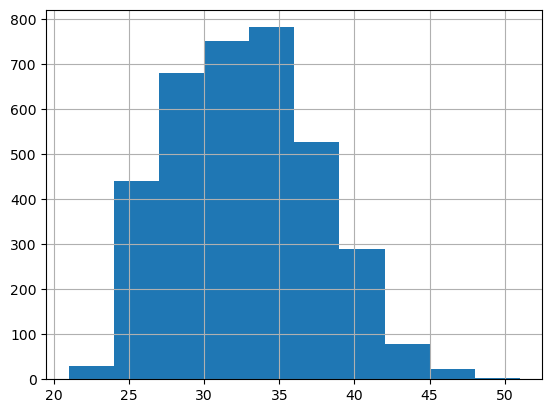

In [34]:
print(players.age.hist())
print(players.playerCountry.unique())
print(players.info())
players.head()

In [35]:
print(events.eventName.unique())
print(events.info())
events.head()

['Pass' 'Duel' 'Foul' 'Free Kick' 'Shot' 'Save attempt'
 'Others on the ball' 'Interruption' 'Goalkeeper leaving line' 'Offside']
<class 'pandas.core.frame.DataFrame'>
Index: 3251294 entries, 0 to 101758
Data columns (total 12 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   eventName    object 
 2   teamId       int64  
 3   playerId     int64  
 4   matchId      int64  
 5   matchPeriod  object 
 6   eventSec     float64
 7   start_x      int64  
 8   start_y      int64  
 9   end_x        float64
 10  end_y        float64
 11  tags         object 
dtypes: float64(3), int64(6), object(3)
memory usage: 322.5+ MB
None


,id,eventName,teamId,playerId,matchId,matchPeriod,eventSec,start_x,start_y,end_x,end_y,tags
0,177959171,Pass,1609,25413,2499719,1H,2.758649,49,49,31.0,78.0,[1801]
1,177959172,Pass,1609,370224,2499719,1H,4.946850,31,78,51.0,75.0,[1801]
2,177959173,Pass,1609,3319,2499719,1H,6.542188,51,75,35.0,71.0,[1801]
3,177959174,Pass,1609,120339,2499719,1H,8.143395,35,71,41.0,95.0,[1801]
4,177959175,Pass,1609,167145,2499719,1H,10.302366,41,95,72.0,88.0,[1801]


# Feature Engineering

In [36]:
# extract event details
events['goal'] = events['tags'].apply(lambda x: 101 in x).astype(int)
events['assist'] = events['tags'].apply(lambda x: 301 in x).astype(int)
events['keyPass'] = events['tags'].apply(lambda x: 302 in x).astype(int)
events['counterAttack'] = events['tags'].apply(lambda x: 1901 in x).astype(int)
events['interception'] = events['tags'].apply(lambda x: 1401 in x).astype(int)
events['clearance'] = events['tags'].apply(lambda x: 1501 in x).astype(int)
events['foot'] = events['tags'].apply(lambda x: 401 in x or 402 in x).astype(int)
events['success'] = events['tags'].apply(lambda x: 1801 in x).astype(int)

# spatial features
events['distance_x'] = events['end_x'] - events['start_x']
events['distance_y'] = events['end_y'] - events['start_y']
events['distance'] = (events['distance_x']**2 + events['distance_y']**2)**0.5

goal_x = 100
goal_y_min = 37
goal_y_max = 63

events['goal_distance'] = ((goal_x - events['start_x'])**2 + (goal_y_max - events['start_y'])**2)**0.5
events['goal_angle'] = events.apply(lambda row: np.arctan2((goal_y_min + goal_y_max) / 2 - row['start_y'], goal_x - row['start_x']), axis=1)

In [49]:
matches = events['matchId'].unique()

for matchId in matches:
    events_match = events[events['matchId'] == matchId]
    events_match = events_match.sort_values(by='id', ascending=True).reset_index(drop=True)
    for half in ['1H', '2H']:
        events_half = events_match[events_match['matchPeriod'] == half]
        for i, row in events_half.iterrows():
            df_window = events_half.iloc[i:i+10]
            if df_window['goal'].max() == 1:
                goal_teamId = df_window[df_window['goal'] == 1]['teamId'].values[0]
                if row['teamId'] == goal_teamId:
                    events.loc[events['id'] == row['id'], 'goalscored'] = 1


In [50]:
events

,id,eventName,teamId,playerId,matchId,matchPeriod,eventSec,start_x,start_y,end_x,...,clearance,foot,success,distance_x,distance_y,distance,goal_distance,goal_angle,label,goalscored
0,177959171,Pass,1609,25413,2499719,1H,2.758649,49,49,31.0,...,1,0,1,-18.0,29.0,34.132096,52.886671,0.019605,other,0
1,177959172,Pass,1609,370224,2499719,1H,4.946850,31,78,51.0,...,1,0,1,20.0,-3.0,20.223748,70.611614,-0.385494,other,0
2,177959173,Pass,1609,3319,2499719,1H,6.542188,51,75,35.0,...,1,0,1,-16.0,-4.0,16.492423,50.447993,-0.471778,other,0
3,177959174,Pass,1609,120339,2499719,1H,8.143395,35,71,41.0,...,1,0,1,6.0,24.0,24.738634,65.490457,-0.312492,other,0
4,177959175,Pass,1609,167145,2499719,1H,10.302366,41,95,72.0,...,1,0,1,31.0,-7.0,31.780497,67.119297,-0.651587,other,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101754,263885652,Pass,9598,3476,2058017,2H,2978.301867,46,20,64.0,...,1,0,1,18.0,-14.0,22.803509,69.028979,0.507099,NaN,0
101755,263885653,Others on the ball,9598,14812,2058017,2H,2979.084611,64,6,82.0,...,0,0,0,18.0,-4.0,18.439089,67.416615,0.885067,NaN,0
101756,263885654,Pass,9598,14812,2058017,2H,2983.448628,82,2,100.0,...,0,1,0,18.0,98.0,99.639350,63.600314,1.212026,NaN,0
101757,263885613,Goalkeeper leaving line,4418,25381,2058017,2H,2985.869275,0,0,18.0,...,0,0,0,18.0,98.0,99.639350,118.190524,0.463648,NaN,0
